In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# 设置路径：请根据实际路径修改，如果你放在了 “我的云端硬盘” 根目录下就不需要修改
project_path = '/content/drive/MyDrive/AE_VAE_Anomaly_Project'

# 切换当前目录到项目文件夹
os.chdir(project_path)

# 检查目录下的内容
!ls

dissertation1.ipynb  tsne_initial_2d.png  UNSW-NB15_1.csv


In [4]:
# === Step 3: 安装所需库（如没安装）===
!pip install shap scikit-learn matplotlib seaborn

# 如果你用了 PyTorch 或 TensorFlow，也加上这句：
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib inline

import time
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

import random as rn
RANDOM_SEED = 42
TRAINING_SAMPLE = 7000 #注意改！
VALIDATE_SIZE = 0.2
# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import shap
import warnings
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

import keras
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
mse = MeanSquaredError()
binary_crossentropy = BinaryCrossentropy()
from tensorflow.keras import layers
from keras import losses
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout, Embedding, LSTM
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras import regularizers

In [4]:
data_path = '/content/drive/MyDrive/AE_VAE_Anomaly_Project/UNSW-NB15_1.csv'
data = pd.read_csv(data_path, header=None)

col_name = ["srcip", "sport", "dstip", "dsport", "proto", "state",
            "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss",
            "service", "sload", "dload", "spkts", "dpkts", "swin", "dwin",
            "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
            "sjit", "djit", "stime", "ltime", "sintpkt", "dintpkt", "tcprtt",
            "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
            "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm",
            "ct_src_ ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
            "attack_cat", "label"]

data.columns = col_name

In [5]:
with open(data_path) as f:
    line_count = sum(1 for line in f)

print("Total lines (including header):", line_count)

Total lines (including header): 700001


In [6]:
total_rows = line_count - 1
print("Total rows (excluding header):", total_rows)

Total rows (excluding header): 700000


In [7]:
# 设置总行数（大概估计或先用 len(open(file).readlines()) 获取）
total_rows = 700000  # 你数据集中实际的行数
sample_size = 10000  # 你想抽样的数量

# 生成要跳过的行号
skip = sorted(np.random.choice(np.arange(1, total_rows), total_rows - sample_size, replace=False))

# 读取抽样数据
data = pd.read_csv(data_path,
                 skiprows=skip, header=None)
col_name = ["srcip", "sport", "dstip", "dsport", "proto", "state",
            "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss",
            "service", "sload", "dload", "spkts", "dpkts", "swin", "dwin",
            "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
            "sjit", "djit", "stime", "ltime", "sintpkt", "dintpkt", "tcprtt",
            "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
            "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm",
            "ct_src_ ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
            "attack_cat", "label"]

data.columns = col_name

In [8]:
def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

data = reduce_mem_usage(data)

Memory usage of dataframe is 3.74 MB
Memory usage after optimization is: 1.58 MB
Decreased by 57.7%


In [9]:
# deal with duplicates
print(f"There are {data.duplicated().sum()} duplicates in the dataset.")

There are 18 duplicates in the dataset.


In [10]:
#delete duplicates
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
df = data.drop(columns=["srcip", "sport", "dstip", "dsport", "stime", "ltime", "attack_cat"])

In [12]:
# check data type and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   proto             9983 non-null   object 
 1   state             9983 non-null   object 
 2   dur               9983 non-null   float32
 3   sbytes            9983 non-null   int32  
 4   dbytes            9983 non-null   int32  
 5   sttl              9983 non-null   int16  
 6   dttl              9983 non-null   int16  
 7   sloss             9983 non-null   int16  
 8   dloss             9983 non-null   int16  
 9   service           9983 non-null   object 
 10  sload             9983 non-null   float32
 11  dload             9983 non-null   float32
 12  spkts             9983 non-null   int16  
 13  dpkts             9983 non-null   int16  
 14  swin              9983 non-null   int16  
 15  dwin              9983 non-null   int16  
 16  stcpb             9983 non-null   int64  


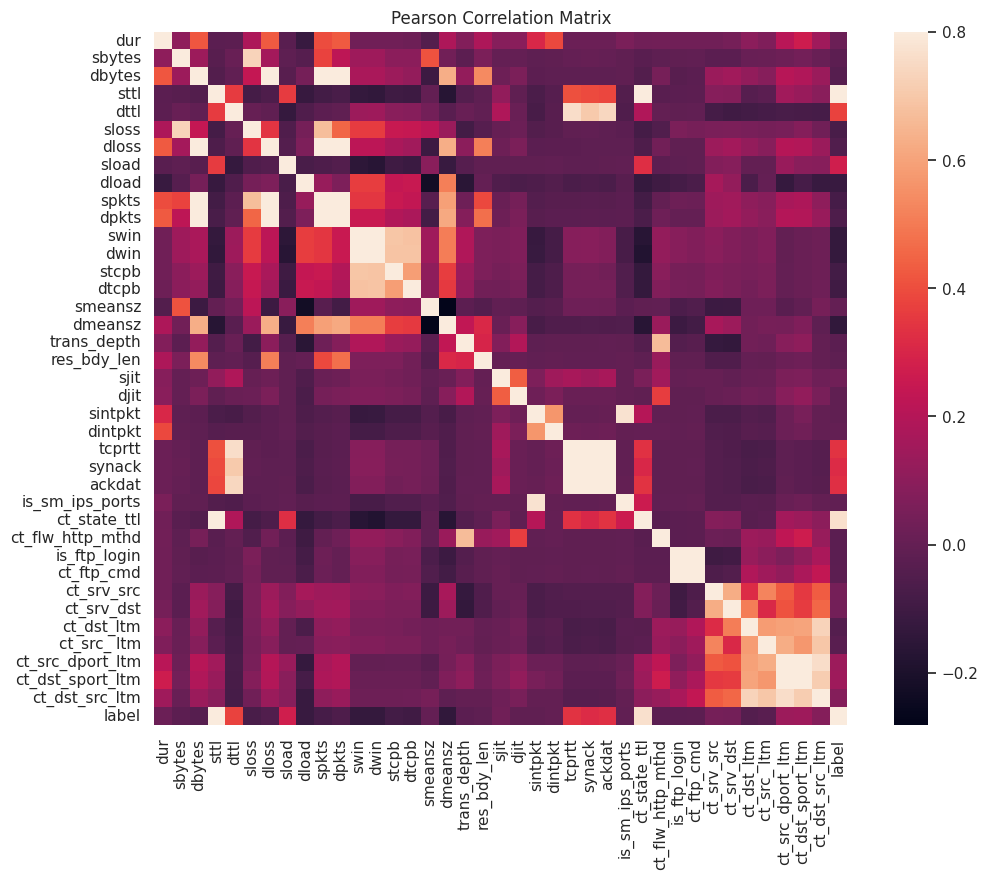

In [13]:
# check correlation between numeric features
def show_correlation(df, method='pearson'):
    df = df.select_dtypes(include=[np.number])  # 只保留数值型列
    correlation_matrix = df.corr(method=method)  # 可选 'pearson', 'kendall', 'spearman'
    fig = plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, vmax=0.8, square=True)
    plt.title(f"{method.title()} Correlation Matrix")
    plt.show()
    return correlation_matrix

correlation_matrix = show_correlation(df)

In [14]:
# get features with high corrs
def top_correlations(correlations, limit=0.98):
    columns = correlations.columns
    for i in range(correlations.shape[0]):
        for j in range(i+1, correlations.shape[0]):
            if correlations.iloc[i,j] >= limit:
                print(f"{columns[i]} {columns[j]} {correlations.iloc[i,j]}")

top_correlations(correlation_matrix, limit=0.98)

dbytes dloss 0.9898451320011155
dloss dpkts 0.9920692302959145
swin dwin 0.9976187857789651


In [15]:
# separate data based on label
normal_data = df[df['label']==0]
anomaly_data = df[df['label']==1]

In [16]:
# define EDA functions
def catplot(data, col):
    ax = sns.catplot(x=col, hue="label",data=data, kind="count", height=5, legend=False, aspect=1.4)
    ax.add_legend(loc='upper right',labels=['normal','attack'])
    plt.show(ax)

def create_count_df(col, data=df):
    dataframe = pd.DataFrame(data[col].value_counts().reset_index().values, columns = [col, 'count'])
    dataframe['percent'] = dataframe['count'].values*100/data.shape[0]
    return dataframe.sort_values(by='percent', ascending=False)

In [17]:
# check data distribution
create_count_df('label')  # 97.77% vs 2.23%

,label,count,percent
0,0,9677,96.934789
1,1,306,3.065211


In [18]:
# check "state"注意这里因为选了小样本导致state本身数量就少，原来大样本还有其他处理，变成大样本时别忘了
create_count_df('state')

,state,count,percent
0,FIN,6893,69.047381
1,CON,2733,27.37654
2,INT,322,3.225483
3,REQ,32,0.320545
4,URH,2,0.020034
5,CLO,1,0.010017


In [19]:
#check "servive"注意这里大样本时也加了一个操作
df.loc[df["service"] == "-", "service"] = "not_much_used"
create_count_df('service')#More than half of the service data are of 'not_much_used' category

,service,count,percent
0,not_much_used,6158,61.684864
1,dns,1763,17.660022
2,http,750,7.512772
3,ftp-data,509,5.098668
4,smtp,340,3.40579
5,ftp,231,2.313934
6,ssh,230,2.303917
7,pop3,2,0.020034


In [20]:
#check "proto"
create_count_df("proto", normal_data)# Normal connections of dataset have only 5 protocols

,proto,count,percent
0,tcp,6881,71.106748
1,udp,2700,27.901209
2,arp,67,0.692363
3,ospf,26,0.268678
4,icmp,2,0.020668
5,igmp,1,0.010334


In [21]:
create_count_df("proto", anomaly_data)# while anomaly connections have 30 protos

,proto,count,percent
0,udp,144,47.058824
1,tcp,110,35.947712
2,unas,19,6.20915
3,ospf,3,0.980392
4,mobile,2,0.653595
5,qnx,2,0.653595
6,ttp,2,0.653595
24,stp,1,0.326797
21,iatp,1,0.326797
22,compaq-peer,1,0.326797


In [22]:
df.loc[df["proto"].isin(['igmp', 'esp', 'rtp', 'udt']), 'proto'] = 'igmp_esp_rtp_udt'
#convert all other protocols into same value
df.loc[~df['proto'].isin(['tcp', 'udp', 'arp', 'ospf', 'icmp', 'igmp_esp_rtp_udt']), 'proto'] = 'others'

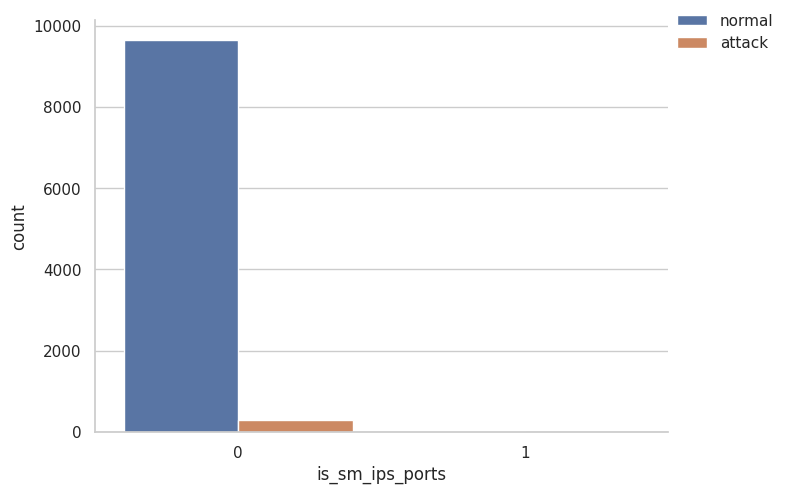

In [23]:
# check "is_sm_ips_ports"
catplot(df, 'is_sm_ips_ports')# Seems if it is 1, then the connection is always normal.

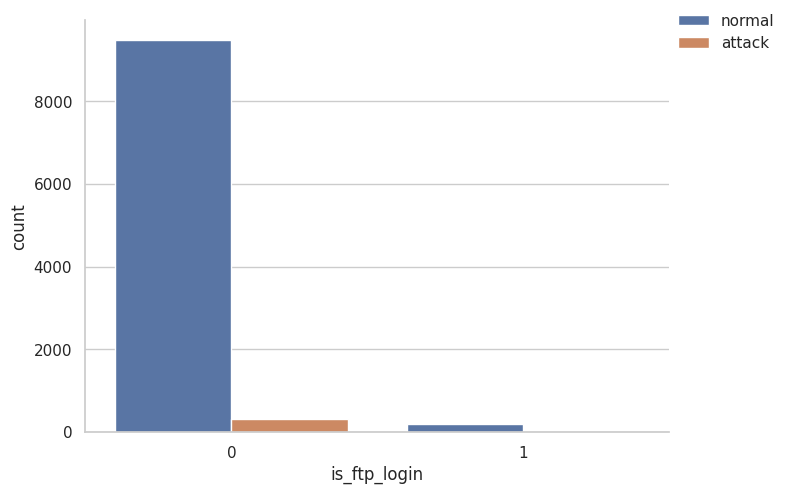

In [24]:
# check "is_ftp_login"
catplot(df, 'is_ftp_login')# If the ftp session is accessed by user and password then 1 else 0

In [25]:
# check "sbytes & dbytes"
print(df['sbytes'].corr(df['sloss']), df['dbytes'].corr(df['dloss']))
#they are closely related to sloss and dloss. So we can drop these 2 here.
df.drop(['sbytes', 'dbytes'], axis=1, inplace=True)

0.7318630033276979 0.9898451320011189


In [26]:
# Except 0 and 255 other values(1-254) occur mostly once only
df['swin'].value_counts().loc[lambda x: x>1]

,count
swin,
255,6991
0,2992


In [27]:
df['dwin'].value_counts().loc[lambda x: x>1]

,count
dwin,
255,6981
0,3002


In [28]:
# So we can separate them into 3 groups. And we also see after binning their correlation with target remains same.
print(df['label'].corr(df['swin']), df['label'].corr(df['dwin']))
selected = ['swin', 'dwin']
kbins = preprocessing.KBinsDiscretizer(n_bins=[3, 3], encode='ordinal', strategy='uniform')
df[selected] = pd.DataFrame(kbins.fit_transform(df[selected]), columns=selected)
print(df['label'].corr(df['swin']), df['label'].corr(df['dwin']))

-0.13228712907266615 -0.13177272780991459
-0.1322871290726665 -0.13177272780991445


In [29]:
# delete as it's highly related with dwin
df.drop(['swin'], axis=1, inplace=True)

In [30]:
#it's just the sum of other two features, it doesn't add any extra info to our models. So we can just drop it for now.
df.drop(['tcprtt'], axis=1, inplace=True)

In [31]:
# Apply log function to all other numerical features, since they are all mostly skewed to the right
col_to_log = []
for col in df.columns:
    if col not in ['state', 'service', 'proto', 'label', 'is_sm_ips_ports', 'is_ftp_login', 'dwin']:
        col_to_log.append(col)

for i in col_to_log:
    df['log10_'+ i] = np.log10(df[i] + 0.00001)
    df.drop([i], axis=1, inplace=True)

In [32]:
df[['is_sm_ips_ports', 'is_ftp_login']] = df[['is_sm_ips_ports', 'is_ftp_login']].astype('object')
df = pd.get_dummies(df)

In [33]:
# separate new dataset
anomaly = df[df.label == 1]
normal = df[df.label == 0]

In [34]:
# manual parameter
RATIO_TO_FRAUD = 10

# splitting by class
anomaly_use = anomaly.sample(frac = 0.1, replace = False, random_state = RANDOM_SEED)
normal_use = normal.sample(frac = 0.1, replace = False, random_state = RANDOM_SEED)

# undersample normal interactions
normal_undersampled = normal_use.sample(
    int(len(anomaly_use) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED)

# concatenate with anomaly interactions into a single dataframe
visualisation_initial = pd.concat([anomaly_use, normal_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [35]:
print(f"""The normal interaction dataset has been undersampled from {len(normal_use):,} to {len(normal_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The normal interaction dataset has been undersampled from 968 to 310.
This represents a ratio of 10:1 to fraud.


In [36]:
# define a function to display clusters of normal and abnormal data
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

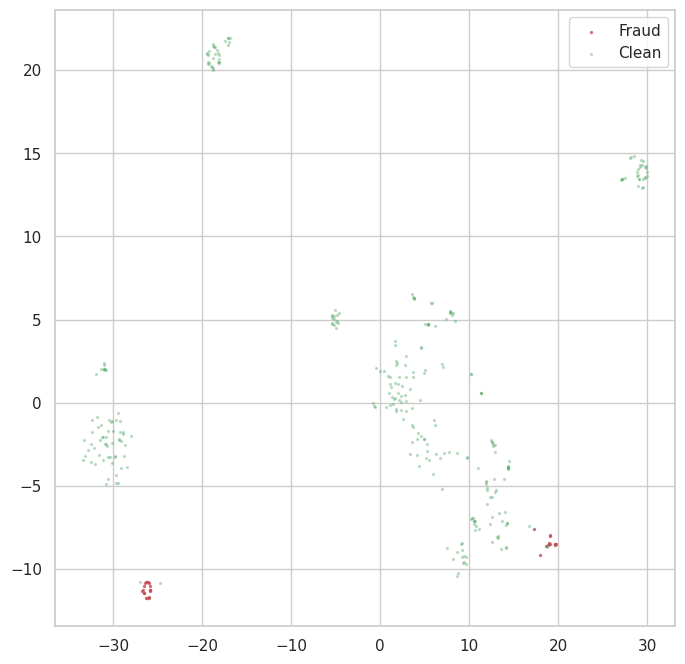

In [37]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')
#Some clusters are apparent, but a minority of fraud transactions remains sneaky, sneaky.

In [38]:
print(f"""Shape of the datasets:
    normal (rows, cols) = {normal.shape}
    anomaly (rows, cols) = {anomaly.shape}""")

Shape of the datasets:
    normal (rows, cols) = (9677, 58)
    anomaly (rows, cols) = (306, 58)


In [39]:
# shuffle our training set
normal = normal.sample(frac=1).reset_index(drop=True)

# training set: exlusively normal interactions
X_train = normal.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining normal + all the anomaly
X_test = pd.concat([normal.iloc[TRAINING_SAMPLE:], anomaly]).sample(frac=1)

In [40]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")

Our testing set is composed as follows:

label
0    2677
1     306
Name: count, dtype: int64


In [41]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all normal anyway
X_train, X_validate = train_test_split(X_train,
                                       test_size=VALIDATE_SIZE,
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [42]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (5600, 57)
    validate (rows, cols) = (1400, 57)
    holdout  (rows, cols) = (2983, 57)


In [43]:
scaler = StandardScaler().fit(pd.concat([X_train, X_validate]))
X_train_transformed = scaler.transform(X_train)
X_validate_transformed = scaler.transform(X_validate)
X_test_transformed = scaler.transform(X_test)

In [44]:
#AE
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_ae(input_dim, encoding_dim):#在这里可以设计浅层深层对比试验
    inp = Input((input_dim,))
    # Encoder
    x = Dense(64, activation='relu')(inp)
    #在浅层网络中，一般 在第一层和倒数第二层加 BN/Dropout 已经足够
    x = BatchNormalization()(x)#批归一化：在每个 batch 内将输出规范化（零均值单位方差），可加快训练、提高稳定性
    #可加入L2/L1 正则化，提升泛化
    x = Dropout(0.2)(x)#防止过拟合，20% 的神经元在训练中被随机“丢弃”
    x = Dense(32, activation='relu')(x)
    bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(x)#瓶颈层：编码器的最小维度，压缩后的表示。你可以将这一层的输出用于可视化或做异常检测
    # Decoder
    x = Dense(32, activation='relu')(bottleneck)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(input_dim, activation='linear')(x)#使用 linear 激活表示不进行非线性变换，输出尽量重构原始输入
    return Model(inp, out)

def train_autoencoder(model, X_train, X_val,
                      batch_size=64,
                      epochs=100,
                      learning_rate=1e-3,
                      save_path='best_ae.h5'):
    """
    训练 Autoencoder 的封装函数

    参数：
        model: 已构建好的 Keras 模型（如 build_ae() 或 build_ae_deep()）
        X_train: 训练输入数据
        X_val: 验证输入数据
        batch_size: 每个 batch 的样本数量
        epochs: 最大训练轮数
        learning_rate: 初始学习率
        save_path: 最优模型保存路径（.h5 文件）

    返回：
        history: 训练日志对象
        model: 训练好的模型（恢复到最优权重）
    """

    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    # 回调函数配置
    es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    mc = ModelCheckpoint(
        save_path,
        monitor='val_loss',
        save_best_only=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    callbacks = [es, mc, lr_scheduler]

    # 训练模型
    history = model.fit(
        X_train, X_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, X_val),
        callbacks=callbacks,
        verbose=1
    )

    return history, model

In [45]:
# 先构建模型
autoencoder = build_ae(input_dim=X_train.shape[1], encoding_dim=16)

# 调用封装训练函数
history, best_model = train_autoencoder(autoencoder, X_train_transformed, X_validate_transformed)

Epoch 1/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9823 - mae: 0.6219

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.9798 - mae: 0.6198 - val_loss: 0.6694 - val_mae: 0.4372 - learning_rate: 0.0010
Epoch 2/100
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5217 - mae: 0.3790

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5216 - mae: 0.3778 - val_loss: 0.4482 - val_mae: 0.3284 - learning_rate: 0.0010
Epoch 3/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4071 - mae: 0.3358

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4079 - mae: 0.3354 - val_loss: 0.3230 - val_mae: 0.2626 - learning_rate: 0.0010
Epoch 4/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3337 - mae: 0.3080

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3348 - mae: 0.3079 - val_loss: 0.2652 - val_mae: 0.2389 - learning_rate: 0.0010
Epoch 5/100
75/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2987 - mae: 0.2945

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3006 - mae: 0.2936 - val_loss: 0.2477 - val_mae: 0.2224 - learning_rate: 0.0010
Epoch 6/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2721 - mae: 0.2815

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2737 - mae: 0.2812 - val_loss: 0.2233 - val_mae: 0.2102 - learning_rate: 0.0010
Epoch 7/100
77/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2563 - mae: 0.2746

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2584 - mae: 0.2740 - val_loss: 0.2172 - val_mae: 0.2007 - learning_rate: 0.0010
Epoch 8/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2437 - mae: 0.2694

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2453 - mae: 0.2688 - val_loss: 0.1751 - val_mae: 0.1982 - learning_rate: 0.0010
Epoch 9/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2283 - mae: 0.2617

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2305 - mae: 0.2612 - val_loss: 0.1730 - val_mae: 0.1946 - learning_rate: 0.0010
Epoch 10/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2246 - mae: 0.2591

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2259 - mae: 0.2585 - val_loss: 0.1578 - val_mae: 0.1929 - learning_rate: 0.0010
Epoch 11/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2035 - mae: 0.2504

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2058 - mae: 0.2501 - val_loss: 0.1465 - val_mae: 0.1871 - learning_rate: 0.0010
Epoch 12/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2004 - mae: 0.2467

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2015 - mae: 0.2467 - val_loss: 0.1308 - val_mae: 0.1780 - learning_rate: 0.0010
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1953 - mae: 0.2440 - val_loss: 0.1478 - val_mae: 0.1823 - learning_rate: 0.0010
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1912 - mae: 0.2410 - val_loss: 0.1358 - val_mae: 0.1760 - learning_rate: 0.0010
Epoch 15/100
74/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1848 - mae: 0.2409
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1879 - mae: 0.2404 - val_loss: 0.1451 - val_mae: 0.1740 - learning_rate: 0.0010
Epoch 16/100
76/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1823 - mae: 0.2360

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1839 - mae: 0.2354 - val_loss: 0.1256 - val_mae: 0.1655 - learning_rate: 5.0000e-04
Epoch 17/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1797 - mae: 0.2344 - val_loss: 0.1274 - val_mae: 0.1678 - learning_rate: 5.0000e-04
Epoch 18/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1746 - mae: 0.2313

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1756 - mae: 0.2312 - val_loss: 0.1238 - val_mae: 0.1689 - learning_rate: 5.0000e-04
Epoch 19/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1716 - mae: 0.2320 - val_loss: 0.1289 - val_mae: 0.1695 - learning_rate: 5.0000e-04
Epoch 20/100
80/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1690 - mae: 0.2306

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1711 - mae: 0.2304 - val_loss: 0.1220 - val_mae: 0.1646 - learning_rate: 5.0000e-04
Epoch 21/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1749 - mae: 0.2303

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1758 - mae: 0.2302 - val_loss: 0.1091 - val_mae: 0.1628 - learning_rate: 5.0000e-04
Epoch 22/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1674 - mae: 0.2280

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1682 - mae: 0.2280 - val_loss: 0.1037 - val_mae: 0.1588 - learning_rate: 5.0000e-04
Epoch 23/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1694 - mae: 0.2280 - val_loss: 0.1050 - val_mae: 0.1606 - learning_rate: 5.0000e-04
Epoch 24/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1711 - mae: 0.2276 - val_loss: 0.1152 - val_mae: 0.1636 - learning_rate: 5.0000e-04
Epoch 25/100
83/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1604 - mae: 0.2244
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1620 - mae: 0.2243 - val_loss: 0.1213 - val_mae: 0.1646 - learning_rate: 5.0000e-04
Epoch 26/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1658 - mae: 0.2247 - val_loss: 0.1136 - val_mae: 0.1613 - learning_rate: 2.5000e-04
Epoch 27/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1643 - mae: 0.2233 - val_loss: 0.1221 - val_mae: 0.1625 - learning_rate: 2.5

In [46]:
import matplotlib.pyplot as plt

def plot_training_history(history, save_path='training_plot.png'):
    """
    绘制并保存训练过程的 Loss 和 MAE 曲线图

    参数：
        history: model.fit() 的返回值
        save_path: 保存图像的文件名（默认 'training_plot.png'）
    """
    plt.figure(figsize=(12, 5))

    # 1. 绘制 Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 2. 绘制 MAE 曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE Over Epochs')
    plt.legend()

    plt.tight_layout()

    # 显示图像
    plt.show()

    # 保存图像
    plt.savefig(save_path)
    print(f'✅ 训练图已保存为: {save_path}')

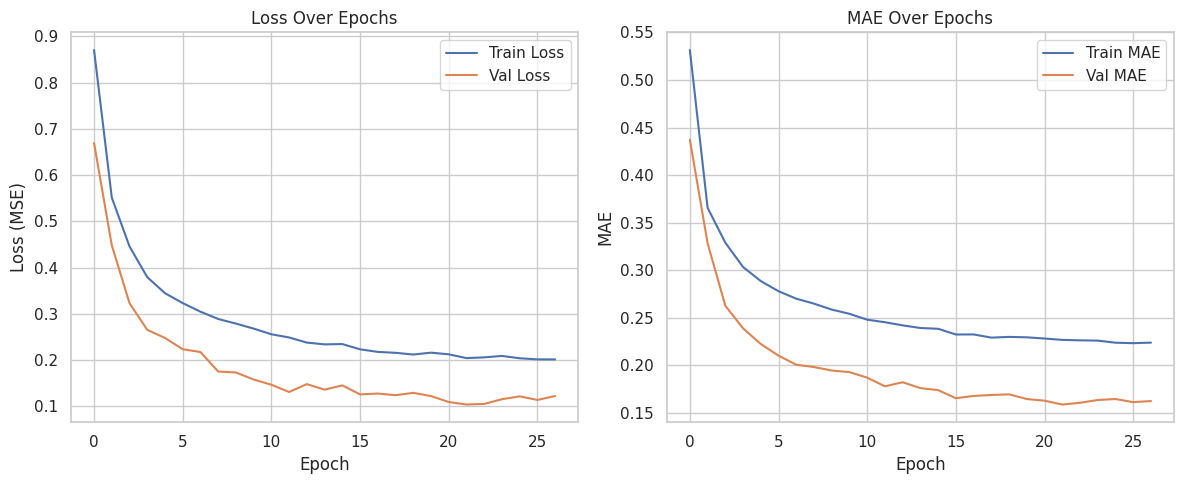

✅ 训练图已保存为: ae_training_plot.png


<Figure size 640x480 with 0 Axes>

In [47]:
# 显示并保存图像,图像将保存在当前 Colab 工作目录中（可从左侧「Files」下载）
plot_training_history(history, save_path='ae_training_plot.png')

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, input_dim, encoding_dim=16, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder_input = layers.Input(shape=(input_dim,))
        self.encoder_hidden = layers.Dense(64, activation='relu')
        self.encoder_bn = layers.BatchNormalization()
        self.encoder_dropout = layers.Dropout(0.2)
        self.encoder_hidden2 = layers.Dense(32, activation='relu')
        self.z_mean_layer = layers.Dense(encoding_dim, name='z_mean')
        self.z_log_var_layer = layers.Dense(encoding_dim, name='z_log_var')
        self.sampling = Sampling()

        self.decoder_hidden = layers.Dense(32, activation='relu')
        self.decoder_bn = layers.BatchNormalization()
        self.decoder_dropout = layers.Dropout(0.2)
        self.decoder_hidden2 = layers.Dense(64, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='linear')

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        x = self.encoder_hidden(inputs)
        x = self.encoder_bn(x)
        x = self.encoder_dropout(x)
        x = self.encoder_hidden2(x)

        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        z = self.sampling((z_mean, z_log_var))

        x = self.decoder_hidden(z)
        x = self.decoder_bn(x)
        x = self.decoder_dropout(x)
        x = self.decoder_hidden2(x)
        return self.decoder_output(x)

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        # 前向传播（与 train_step 相同）
        x = self.encoder_hidden(data)
        x = self.encoder_bn(x, training=False)
        x = self.encoder_dropout(x, training=False)
        x = self.encoder_hidden2(x)

        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        z = self.sampling((z_mean, z_log_var))

        x_decoded = self.decoder_hidden(z)
        x_decoded = self.decoder_bn(x_decoded, training=False)
        x_decoded = self.decoder_dropout(x_decoded, training=False)
        x_decoded = self.decoder_hidden2(x_decoded)
        output = self.decoder_output(x_decoded)

        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - output), axis=1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # 前向传播
            x = self.encoder_hidden(data)
            x = self.encoder_bn(x)
            x = self.encoder_dropout(x)
            x = self.encoder_hidden2(x)

            z_mean = self.z_mean_layer(x)
            z_log_var = self.z_log_var_layer(x)
            z = self.sampling((z_mean, z_log_var))

            x_decoded = self.decoder_hidden(z)
            x_decoded = self.decoder_bn(x_decoded)
            x_decoded = self.decoder_dropout(x_decoded)
            x_decoded = self.decoder_hidden2(x_decoded)
            output = self.decoder_output(x_decoded)

            # 计算 loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - output), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 更新指标
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_vae(model, X_train, X_val,
              batch_size=64,
              epochs=100,
              learning_rate=1e-3,
              save_path='best_vae.h5'):
    """
    训练 Variational Autoencoder 的封装函数

    参数：
        model: 已构建好的 VAE 模型（如 build_vae()）
        X_train: 训练输入数据
        X_val: 验证输入数据
        batch_size: 每个 batch 的样本数量
        epochs: 最大训练轮数
        learning_rate: 初始学习率
        save_path: 最优模型保存路径（.h5 文件）

    返回：
        history: 训练日志对象
        model: 训练好的模型（恢复到最优权重）
    """

    # 设置优化器（注意：VAE 模型内已添加自定义 loss）
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    # 回调函数配置
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    mc = ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                     min_lr=1e-6, verbose=1)

    callbacks = [es, mc, lr_scheduler]

    # 训练模型
    history = model.fit(
        X_train, X_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, X_val),
        callbacks=callbacks,
        verbose=1
    )

    return history, model

In [73]:
def plot_vae_history(history, save_path='vae_loss_plot.png'):
    """
    画出 VAE 的 total_loss、recon_loss、kl_loss 及对应的验证曲线。
    """
    h = history.history
    epochs = range(1, len(h['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # 1) Total Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['loss'],     label='Train Total Loss')
    plt.plot(epochs, h['val_loss'], label='Val Total Loss')
    plt.title('VAE Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2) Recon vs KL
    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['recon_loss'],     label='Train Recon Loss')
    plt.plot(epochs, h['val_recon_loss'], label='Val Recon Loss')
    plt.plot(epochs, h['kl_loss'],        label='Train KL Loss')
    plt.plot(epochs, h['val_kl_loss'],    label='Val KL Loss')
    plt.title('Reconstruction & KL Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f'✅ VAE loss 曲线已保存到 {save_path}')


Epoch 1/100
76/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.3390 - loss: 54.8899 - recon_loss: 52.5510

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - kl_loss: 2.2688 - loss: 54.7263 - recon_loss: 52.4576 - val_kl_loss: 3.4840 - val_loss: 45.5972 - val_recon_loss: 42.1132 - learning_rate: 0.0010
Epoch 2/100
77/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.5346 - loss: 38.7211 - recon_loss: 35.1865

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 3.5718 - loss: 38.7653 - recon_loss: 35.1936 - val_kl_loss: 4.6904 - val_loss: 35.5332 - val_recon_loss: 30.8428 - learning_rate: 0.0010
Epoch 3/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.7291 - loss: 31.1826 - recon_loss: 26.4535

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 4.7397 - loss: 31.2818 - recon_loss: 26.5421 - val_kl_loss: 5.3165 - val_loss: 29.9940 - val_recon_loss: 24.6774 - learning_rate: 0.0010
Epoch 4/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 4.9383 - loss: 27.0746 - recon_loss: 22.1363

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 4.9482 - loss: 27.1873 - recon_loss: 22.2391 - val_kl_loss: 5.5299 - val_loss: 27.4402 - val_recon_loss: 21.9103 - learning_rate: 0.0010
Epoch 5/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.3639 - loss: 24.6416 - recon_loss: 19.2777

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.3709 - loss: 24.7499 - recon_loss: 19.3790 - val_kl_loss: 6.4147 - val_loss: 25.0825 - val_recon_loss: 18.6678 - learning_rate: 0.0010
Epoch 6/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.9537 - loss: 22.3719 - recon_loss: 16.4182

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.9782 - loss: 22.5095 - recon_loss: 16.5313 - val_kl_loss: 6.3880 - val_loss: 22.6395 - val_recon_loss: 16.2515 - learning_rate: 0.0010
Epoch 7/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 6.0848 - loss: 20.8074 - recon_loss: 14.7227

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 6.0895 - loss: 20.9243 - recon_loss: 14.8348 - val_kl_loss: 6.3174 - val_loss: 21.2920 - val_recon_loss: 14.9746 - learning_rate: 0.0010
Epoch 8/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 6.0167 - loss: 20.0477 - recon_loss: 14.0310

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 6.0290 - loss: 20.1801 - recon_loss: 14.1512 - val_kl_loss: 6.4032 - val_loss: 19.4976 - val_recon_loss: 13.0944 - learning_rate: 0.0010
Epoch 9/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 6.0824 - loss: 19.1290 - recon_loss: 13.0466

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 6.0931 - loss: 19.2691 - recon_loss: 13.1760 - val_kl_loss: 6.4666 - val_loss: 18.5199 - val_recon_loss: 12.0533 - learning_rate: 0.0010
Epoch 10/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 6.1039 - loss: 18.9266 - recon_loss: 12.8227

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 6.1092 - loss: 19.0351 - recon_loss: 12.9259 - val_kl_loss: 6.5206 - val_loss: 17.6509 - val_recon_loss: 11.1303 - learning_rate: 0.0010
Epoch 11/100
75/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.9445 - loss: 17.8585 - recon_loss: 11.9141

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 5.9588 - loss: 18.0428 - recon_loss: 12.0839 - val_kl_loss: 6.4429 - val_loss: 17.0827 - val_recon_loss: 10.6398 - learning_rate: 0.0010
Epoch 12/100
75/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 6.0740 - loss: 17.8301 - recon_loss: 11.7561

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 6.0907 - loss: 17.9840 - recon_loss: 11.8933 - val_kl_loss: 6.3342 - val_loss: 16.9877 - val_recon_loss: 10.6535 - learning_rate: 0.0010
Epoch 13/100
75/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.9352 - loss: 17.3541 - recon_loss: 11.4189

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 5.9606 - loss: 17.4961 - recon_loss: 11.5355 - val_kl_loss: 6.3780 - val_loss: 16.6385 - val_recon_loss: 10.2604 - learning_rate: 0.0010
Epoch 14/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.9514 - loss: 17.3160 - recon_loss: 11.3646

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.9656 - loss: 17.3862 - recon_loss: 11.4206 - val_kl_loss: 6.5452 - val_loss: 16.5320 - val_recon_loss: 9.9869 - learning_rate: 0.0010
Epoch 15/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.9621 - loss: 16.8268 - recon_loss: 10.8647

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.9833 - loss: 16.8903 - recon_loss: 10.9070 - val_kl_loss: 6.2877 - val_loss: 16.1306 - val_recon_loss: 9.8429 - learning_rate: 0.0010
Epoch 16/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.8596 - loss: 16.4576 - recon_loss: 10.5981

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.8751 - loss: 16.5023 - recon_loss: 10.6272 - val_kl_loss: 6.2356 - val_loss: 15.7966 - val_recon_loss: 9.5610 - learning_rate: 0.0010
Epoch 17/100
83/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.8142 - loss: 16.1687 - recon_loss: 10.3545

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.8331 - loss: 16.2174 - recon_loss: 10.3843 - val_kl_loss: 5.9732 - val_loss: 15.4387 - val_recon_loss: 9.4655 - learning_rate: 0.0010
Epoch 18/100
72/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.6947 - loss: 15.8523 - recon_loss: 10.1576

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.7341 - loss: 15.9948 - recon_loss: 10.2608 - val_kl_loss: 6.0429 - val_loss: 15.2154 - val_recon_loss: 9.1725 - learning_rate: 0.0010
Epoch 19/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.7213 - loss: 15.6196 - recon_loss: 9.8983

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.7383 - loss: 15.6444 - recon_loss: 9.9061 - val_kl_loss: 6.1024 - val_loss: 14.9488 - val_recon_loss: 8.8464 - learning_rate: 0.0010
Epoch 20/100
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.7060 - loss: 15.3266 - recon_loss: 9.6206

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.7219 - loss: 15.3811 - recon_loss: 9.6591 - val_kl_loss: 6.0234 - val_loss: 14.6397 - val_recon_loss: 8.6164 - learning_rate: 0.0010
Epoch 21/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.6458 - loss: 15.0414 - recon_loss: 9.3956

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.6638 - loss: 15.0712 - recon_loss: 9.4074 - val_kl_loss: 5.9148 - val_loss: 14.4910 - val_recon_loss: 8.5762 - learning_rate: 0.0010
Epoch 22/100
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.5681 - loss: 14.7304 - recon_loss: 9.1622

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.5832 - loss: 14.7966 - recon_loss: 9.2134 - val_kl_loss: 6.0656 - val_loss: 14.2831 - val_recon_loss: 8.2175 - learning_rate: 0.0010
Epoch 23/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.6747 - loss: 14.5617 - recon_loss: 8.8871

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.6946 - loss: 14.6119 - recon_loss: 8.9173 - val_kl_loss: 5.8651 - val_loss: 14.1878 - val_recon_loss: 8.3227 - learning_rate: 0.0010
Epoch 24/100
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.5710 - loss: 14.3595 - recon_loss: 8.7884

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.5894 - loss: 14.3908 - recon_loss: 8.8013 - val_kl_loss: 5.8983 - val_loss: 13.9642 - val_recon_loss: 8.0659 - learning_rate: 0.0010
Epoch 25/100
80/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.6148 - loss: 14.2221 - recon_loss: 8.6072

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.6355 - loss: 14.2482 - recon_loss: 8.6127 - val_kl_loss: 5.9166 - val_loss: 13.9327 - val_recon_loss: 8.0161 - learning_rate: 0.0010
Epoch 26/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.5332 - loss: 13.9857 - recon_loss: 8.4525

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.5529 - loss: 14.0069 - recon_loss: 8.4541 - val_kl_loss: 5.7084 - val_loss: 13.6953 - val_recon_loss: 7.9869 - learning_rate: 0.0010
Epoch 27/100
80/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.4340 - loss: 13.8108 - recon_loss: 8.3767

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.4644 - loss: 13.8264 - recon_loss: 8.3620 - val_kl_loss: 5.7990 - val_loss: 13.5088 - val_recon_loss: 7.7098 - learning_rate: 0.0010
Epoch 28/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 5.5076 - loss: 13.8067 - recon_loss: 8.2992

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 5.5225 - loss: 13.8178 - recon_loss: 8.2953 - val_kl_loss: 5.6112 - val_loss: 13.4493 - val_recon_loss: 7.8381 - learning_rate: 0.0010
Epoch 29/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 5.4347 - loss: 13.5118 - recon_loss: 8.0770

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.4410 - loss: 13.5174 - recon_loss: 8.0764 - val_kl_loss: 5.7335 - val_loss: 13.2921 - val_recon_loss: 7.5585 - learning_rate: 0.0010
Epoch 30/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.4611 - loss: 13.5187 - recon_loss: 8.0576 - val_kl_loss: 5.7583 - val_loss: 13.3069 - val_recon_loss: 7.5486 - learning_rate: 0.0010
Epoch 31/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.5292 - loss: 13.4403 - recon_loss: 7.9110 - val_kl_loss: 5.5834 - val_loss: 13.3024 - val_recon_loss: 7.7190 - learning_rate: 0.0010
Epoch 32/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.4187 - loss: 13.4160 - recon_loss: 7.9974

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.4256 - loss: 13.4464 - recon_loss: 8.0209 - val_kl_loss: 5.4546 - val_loss: 13.0001 - val_recon_loss: 7.5456 - learning_rate: 0.0010
Epoch 33/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.2637 - loss: 13.0062 - recon_loss: 7.7425

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2755 - loss: 13.0135 - recon_loss: 7.7380 - val_kl_loss: 5.5457 - val_loss: 12.9968 - val_recon_loss: 7.4511 - learning_rate: 0.0010
Epoch 34/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.3405 - loss: 13.0238 - recon_loss: 7.6833 - val_kl_loss: 5.5955 - val_loss: 13.2951 - val_recon_loss: 7.6997 - learning_rate: 0.0010
Epoch 35/100
77/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.3432 - loss: 13.1002 - recon_loss: 7.7570

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - kl_loss: 5.3657 - loss: 13.0728 - recon_loss: 7.7071 - val_kl_loss: 5.5065 - val_loss: 12.6225 - val_recon_loss: 7.1161 - learning_rate: 0.0010
Epoch 36/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.2669 - loss: 12.8043 - recon_loss: 7.5374

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.2888 - loss: 12.8027 - recon_loss: 7.5139 - val_kl_loss: 5.3399 - val_loss: 12.4427 - val_recon_loss: 7.1028 - learning_rate: 0.0010
Epoch 37/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2336 - loss: 12.6273 - recon_loss: 7.3937 - val_kl_loss: 5.4385 - val_loss: 12.5779 - val_recon_loss: 7.1394 - learning_rate: 0.0010
Epoch 38/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.1842 - loss: 12.5876 - recon_loss: 7.4034

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.1921 - loss: 12.6019 - recon_loss: 7.4098 - val_kl_loss: 5.4794 - val_loss: 12.3163 - val_recon_loss: 6.8369 - learning_rate: 0.0010
Epoch 39/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2346 - loss: 12.5958 - recon_loss: 7.3612 - val_kl_loss: 5.4401 - val_loss: 12.3304 - val_recon_loss: 6.8903 - learning_rate: 0.0010
Epoch 40/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2349 - loss: 12.3726 - recon_loss: 7.1376 - val_kl_loss: 5.4734 - val_loss: 12.3192 - val_recon_loss: 6.8458 - learning_rate: 0.0010
Epoch 41/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.2313 - loss: 12.3536 - recon_loss: 7.1223

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2482 - loss: 12.3513 - recon_loss: 7.1031 - val_kl_loss: 5.3634 - val_loss: 12.0398 - val_recon_loss: 6.6764 - learning_rate: 0.0010
Epoch 42/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.2470 - loss: 12.4229 - recon_loss: 7.1759 - val_kl_loss: 5.3821 - val_loss: 12.1063 - val_recon_loss: 6.7242 - learning_rate: 0.0010
Epoch 43/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2376 - loss: 12.3031 - recon_loss: 7.0654 - val_kl_loss: 5.3296 - val_loss: 12.2482 - val_recon_loss: 6.9186 - learning_rate: 0.0010
Epoch 44/100
78/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.2056 - loss: 12.1872 - recon_loss: 6.9816
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.2184 - loss: 12.1774 - recon_loss: 6.9589 - val_kl_loss: 5.3329 - val_loss: 12.1434 - val_recon_loss: 6.8105 - learning_rate: 0.0010
Epoch 45/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.1438 - loss: 11.9664 - recon_loss: 6.8226 - val_kl_loss: 5.3163 - val_loss: 11.8054 - val_recon_loss: 6.4891 - learning_rate: 5.0000e-04
Epoch 46/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.1386 - loss: 11.8157 - recon_loss: 6.6771

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.1464 - loss: 11.8183 - recon_loss: 6.6718 - val_kl_loss: 5.3640 - val_loss: 11.7009 - val_recon_loss: 6.3369 - learning_rate: 5.0000e-04
Epoch 47/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.1326 - loss: 11.7437 - recon_loss: 6.6111

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.1475 - loss: 11.7401 - recon_loss: 6.5926 - val_kl_loss: 5.2721 - val_loss: 11.5827 - val_recon_loss: 6.3106 - learning_rate: 5.0000e-04
Epoch 48/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 5.1111 - loss: 11.8036 - recon_loss: 6.6924

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.1210 - loss: 11.8013 - recon_loss: 6.6803 - val_kl_loss: 5.2671 - val_loss: 11.5670 - val_recon_loss: 6.2999 - learning_rate: 5.0000e-04
Epoch 49/100
77/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.0999 - loss: 11.7806 - recon_loss: 6.6806

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.1235 - loss: 11.7618 - recon_loss: 6.6382 - val_kl_loss: 5.2733 - val_loss: 11.5295 - val_recon_loss: 6.2562 - learning_rate: 5.0000e-04
Epoch 50/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.0913 - loss: 11.6150 - recon_loss: 6.5237 - val_kl_loss: 5.3017 - val_loss: 11.5623 - val_recon_loss: 6.2606 - learning_rate: 5.0000e-04
Epoch 51/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.1224 - loss: 11.6564 - recon_loss: 6.5341

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.1337 - loss: 11.6523 - recon_loss: 6.5186 - val_kl_loss: 5.2176 - val_loss: 11.4333 - val_recon_loss: 6.2157 - learning_rate: 5.0000e-04
Epoch 52/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.0608 - loss: 11.5478 - recon_loss: 6.4870

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.0708 - loss: 11.5501 - recon_loss: 6.4793 - val_kl_loss: 5.4465 - val_loss: 11.4050 - val_recon_loss: 5.9584 - learning_rate: 5.0000e-04
Epoch 53/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.1089 - loss: 11.5272 - recon_loss: 6.4183 - val_kl_loss: 5.3683 - val_loss: 11.4916 - val_recon_loss: 6.1233 - learning_rate: 5.0000e-04
Epoch 54/100
80/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.1424 - loss: 11.5680 - recon_loss: 6.4256

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.1546 - loss: 11.5585 - recon_loss: 6.4039 - val_kl_loss: 5.3623 - val_loss: 11.3955 - val_recon_loss: 6.0332 - learning_rate: 5.0000e-04
Epoch 55/100
74/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.1035 - loss: 11.5644 - recon_loss: 6.4609

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.1208 - loss: 11.5401 - recon_loss: 6.4193 - val_kl_loss: 5.1812 - val_loss: 11.3309 - val_recon_loss: 6.1497 - learning_rate: 5.0000e-04
Epoch 56/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.0638 - loss: 11.3926 - recon_loss: 6.3288 - val_kl_loss: 5.2486 - val_loss: 11.4843 - val_recon_loss: 6.2357 - learning_rate: 5.0000e-04
Epoch 57/100
77/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.0629 - loss: 11.4087 - recon_loss: 6.3457

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.0840 - loss: 11.3969 - recon_loss: 6.3128 - val_kl_loss: 5.2741 - val_loss: 11.2469 - val_recon_loss: 5.9727 - learning_rate: 5.0000e-04
Epoch 58/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.0791 - loss: 11.3838 - recon_loss: 6.3048 - val_kl_loss: 5.2755 - val_loss: 11.2660 - val_recon_loss: 5.9905 - learning_rate: 5.0000e-04
Epoch 59/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.0389 - loss: 11.2670 - recon_loss: 6.2281 - val_kl_loss: 5.2575 - val_loss: 11.2766 - val_recon_loss: 6.0191 - learning_rate: 5.0000e-04
Epoch 60/100
72/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.9615 - loss: 11.2561 - recon_loss: 6.2946

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 4.9922 - loss: 11.2472 - recon_loss: 6.2550 - val_kl_loss: 5.1968 - val_loss: 11.1193 - val_recon_loss: 5.9225 - learning_rate: 5.0000e-04
Epoch 61/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.0186 - loss: 11.2360 - recon_loss: 6.2174

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.0223 - loss: 11.2379 - recon_loss: 6.2156 - val_kl_loss: 5.2133 - val_loss: 11.0352 - val_recon_loss: 5.8219 - learning_rate: 5.0000e-04
Epoch 62/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.0307 - loss: 11.2429 - recon_loss: 6.2122 - val_kl_loss: 5.2713 - val_loss: 11.0891 - val_recon_loss: 5.8178 - learning_rate: 5.0000e-04
Epoch 63/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.0884 - loss: 11.2255 - recon_loss: 6.1370 - val_kl_loss: 5.0386 - val_loss: 11.2439 - val_recon_loss: 6.2053 - learning_rate: 5.0000e-04
Epoch 64/100
72/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.9023 - loss: 11.2729 - recon_loss: 6.3706

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 4.9395 - loss: 11.2406 - recon_loss: 6.3010 - val_kl_loss: 5.0584 - val_loss: 10.9533 - val_recon_loss: 5.8949 - learning_rate: 5.0000e-04
Epoch 65/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 4.9329 - loss: 11.0656 - recon_loss: 6.1327 - val_kl_loss: 5.1292 - val_loss: 11.0319 - val_recon_loss: 5.9028 - learning_rate: 5.0000e-04
Epoch 66/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 4.9959 - loss: 11.1955 - recon_loss: 6.1996

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 5.0035 - loss: 11.1955 - recon_loss: 6.1920 - val_kl_loss: 5.1314 - val_loss: 10.9416 - val_recon_loss: 5.8102 - learning_rate: 5.0000e-04
Epoch 67/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.0635 - loss: 11.1972 - recon_loss: 6.1337

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.0723 - loss: 11.1982 - recon_loss: 6.1259 - val_kl_loss: 5.2049 - val_loss: 10.8543 - val_recon_loss: 5.6494 - learning_rate: 5.0000e-04
Epoch 68/100
83/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 5.0582 - loss: 11.1242 - recon_loss: 6.0660

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.0662 - loss: 11.1224 - recon_loss: 6.0562 - val_kl_loss: 5.1558 - val_loss: 10.7893 - val_recon_loss: 5.6335 - learning_rate: 5.0000e-04
Epoch 69/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.0546 - loss: 11.1106 - recon_loss: 6.0560 - val_kl_loss: 5.1881 - val_loss: 10.9073 - val_recon_loss: 5.7192 - learning_rate: 5.0000e-04
Epoch 70/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.0066 - loss: 11.0626 - recon_loss: 6.0559 - val_kl_loss: 5.3527 - val_loss: 10.8945 - val_recon_loss: 5.5418 - learning_rate: 5.0000e-04
Epoch 71/100
79/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.0584 - loss: 11.0219 - recon_loss: 5.9635
Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.0700 - loss: 11.0131 - recon_loss: 5.9431 - val_kl_loss: 5.1692 - val_loss: 10.8283 - val_recon_loss: 5.6591 - learning_rate: 5.0000e-04
Epoch 72/100
77/88 ━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 4.9999 - loss: 10.9443 - recon_loss: 5.9444 - val_kl_loss: 5.1160 - val_loss: 10.7005 - val_recon_loss: 5.5845 - learning_rate: 2.5000e-04
Epoch 73/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 4.9965 - loss: 10.8864 - recon_loss: 5.8898 - val_kl_loss: 5.1234 - val_loss: 10.7869 - val_recon_loss: 5.6635 - learning_rate: 2.5000e-04
Epoch 74/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 4.9707 - loss: 10.8216 - recon_loss: 5.8510 - val_kl_loss: 5.2791 - val_loss: 10.7418 - val_recon_loss: 5.4628 - learning_rate: 2.5000e-04
Epoch 75/100
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 5.0294 - loss: 10.8696 - recon_loss: 5.8402
Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.0381 - loss: 10.8664 - recon_loss: 5.8283 - val_kl_loss: 5.1792 - val_loss: 10.7387 - val_recon_loss: 5.5595 - learning_rate: 2.5000e-04
Epoch 76/100
81/88 ━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 4.9958 - loss: 10.7772 - recon_loss: 5.7814 - val_kl_loss: 5.1073 - val_loss: 10.6501 - val_recon_loss: 5.5428 - learning_rate: 1.2500e-04
Epoch 77/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 4.9570 - loss: 10.7554 - recon_loss: 5.7984 - val_kl_loss: 5.1621 - val_loss: 10.6902 - val_recon_loss: 5.5281 - learning_rate: 1.2500e-04
Epoch 78/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 5.0014 - loss: 10.7305 - recon_loss: 5.7290 - val_kl_loss: 5.1566 - val_loss: 10.7034 - val_recon_loss: 5.5468 - learning_rate: 1.2500e-04
Epoch 79/100
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 4.9895 - loss: 10.7534 - recon_loss: 5.7640
Epoch 79: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 5.0007 - loss: 10.7478 - recon_loss: 5.7470 - val_kl_loss: 5.1491 - val_loss: 10.6982 - val_recon_loss: 5.5492 - learning_rate: 1.2500e-04
Epoch 80/100
88/88 ━━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 4.9538 - loss: 10.6663 - recon_loss: 5.7126 - val_kl_loss: 5.1050 - val_loss: 10.5730 - val_recon_loss: 5.4681 - learning_rate: 6.2500e-05
Epoch 82/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 4.9553 - loss: 10.7251 - recon_loss: 5.7698

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 4.9582 - loss: 10.7256 - recon_loss: 5.7674 - val_kl_loss: 5.1182 - val_loss: 10.5215 - val_recon_loss: 5.4033 - learning_rate: 6.2500e-05
Epoch 83/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 4.9354 - loss: 10.6738 - recon_loss: 5.7384 - val_kl_loss: 5.1338 - val_loss: 10.6886 - val_recon_loss: 5.5548 - learning_rate: 6.2500e-05
Epoch 84/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 4.9602 - loss: 10.6605 - recon_loss: 5.7003 - val_kl_loss: 5.0934 - val_loss: 10.5892 - val_recon_loss: 5.4958 - learning_rate: 6.2500e-05
Epoch 85/100
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 4.9233 - loss: 10.6867 - recon_loss: 5.7634
Epoch 85: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 4.9366 - loss: 10.6793 - recon_loss: 5.7427 - val_kl_loss: 5.1077 - val_loss: 10.6103 - val_recon_loss: 5.5026 - learning_rate: 6.2500e-05
Epoch 86/100
88/88 ━━━━━━━━━━━━━━━

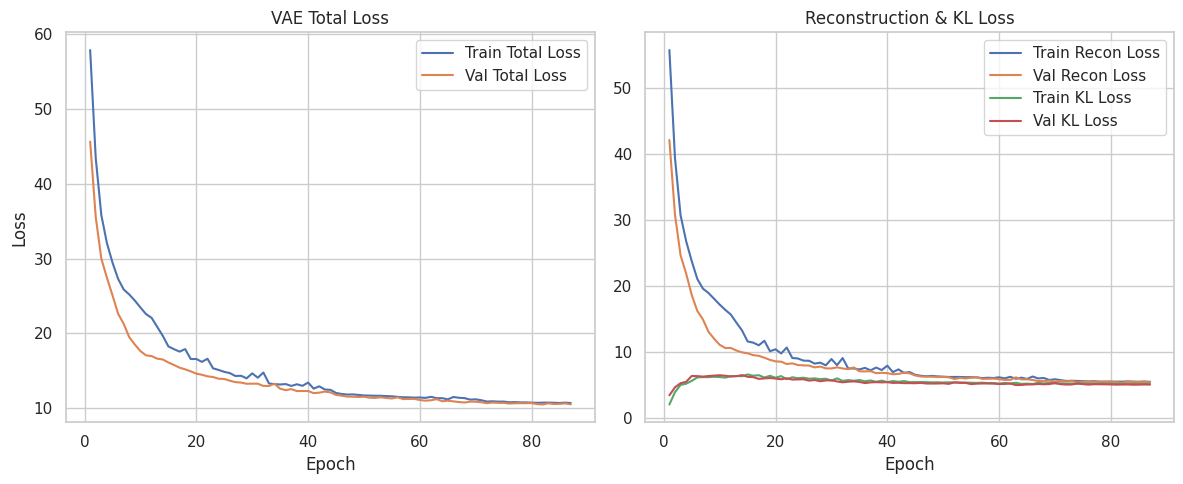

✅ VAE loss 曲线已保存到 vae_training_plot.png


In [74]:
vae = VAE(input_dim=X_train.shape[1], encoding_dim=16)

history_vae, best_vae = train_vae(
    model=vae,
    X_train=X_train_transformed,
    X_val=X_validate_transformed,
    save_path='best_vae.h5'
)
plot_vae_history(history_vae, save_path='vae_training_plot.png')

In [75]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

def evaluate_reconstruction_model(model,
                                  X_train,
                                  X_test,
                                  y_test,
                                  threshold=None,
                                  percentile=95,
                                  model_name='Model'):
    """
    通用重构模型（AE/VAE）异常检测评估函数

    参数：
        model: 已训练好的模型
        X_train: 训练数据（用于设置阈值）
        X_test: 测试数据
        y_test: 测试集真实标签（0=正常, 1=异常）
        threshold: 可选，手动指定阈值（否则使用训练集分位数）
        percentile: 若未提供阈值，则从训练集重构误差中取该分位数作为阈值
        model_name: 模型名，用于打印

    返回：
        y_pred: 预测标签（0正常，1异常）
        threshold: 实际使用的阈值
    """
    # 获取重构结果
    X_train_pred = model.predict(X_train)
    X_test_pred = model.predict(X_test)

    # 计算重构误差（MSE）
    train_errors = np.mean(np.square(X_train_pred - X_train), axis=1)
    test_errors = np.mean(np.square(X_test_pred - X_test), axis=1)

    # 自动计算阈值
    if threshold is None:
        threshold = np.percentile(train_errors, percentile)

    # 判断异常
    y_pred = (test_errors > threshold).astype(int)

    # 打印评估结果
    print(f"\n📊 {model_name} 检测结果 (阈值 = {threshold:.4f}):")
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, test_errors))

    return y_pred, threshold

In [76]:
#评估传统异常检测模型（如 Isolation Forest）

def evaluate_traditional_model(model,
                               X_test,
                               y_test,
                               model_name='Model',
                               anomaly_label=-1):
    """
    用于评估传统异常检测模型的通用函数（Isolation Forest / One-Class SVM / LOF）

    参数：
        model: 已拟合的模型（如 sklearn 的 IsolationForest、OneClassSVM）
        X_test: 测试集特征
        y_test: 测试集真实标签（0=正常, 1=异常）
        model_name: 用于打印的模型名称
        anomaly_label: 模型输出中代表“异常”的标签（默认 -1）

    返回：
        y_pred: 预测标签（0正常，1异常）
    """
    y_pred_raw = model.predict(X_test)
    y_pred = (y_pred_raw == anomaly_label).astype(int)

    print(f"\n📊 {model_name} 检测结果:")
    print(classification_report(y_test, y_pred))

    # 某些传统方法没有 score_samples，可以不显示 AUC
    if hasattr(model, "score_samples") or hasattr(model, "decision_function"):
        try:
            if hasattr(model, "score_samples"):
                scores = -model.score_samples(X_test)
            else:
                scores = -model.decision_function(X_test)

            auc = roc_auc_score(y_test, scores)
            print("AUC:", auc)
        except:
            print("⚠️ 该模型无法计算 AUC。")
    else:
        print("⚠️ 模型未提供可用的异常评分，无法计算 AUC。")

    return y_pred


In [77]:
#比较 AE、VAE 和传统异常检测方法的评估结果表格 + 可视化函数
#1. 定义通用评估结果收集器
def collect_evaluation_metrics(y_true, y_pred, scores=None, model_name='Model'):
    """
    收集精度、召回率、F1 和 AUC 指标，用于多模型比较。
    """
    metrics = {
        'Model': model_name,
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
    }
    if scores is not None:
        try:
            metrics['AUC'] = roc_auc_score(y_true, scores)
        except:
            metrics['AUC'] = None
    else:
        metrics['AUC'] = None

    return metrics


#2. 所有模型评估完之后：生成对比表格
def display_comparison_table(results_list):
    """
    将多个模型的评估指标整合为 DataFrame 并按 F1 或 AUC 排序展示。
    """
    df = pd.DataFrame(results_list)
    df_sorted = df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
    print("\n📋 模型性能比较：")
    print(df_sorted.to_string(index=False))
    return df_sorted

#3. 可选：绘制各方法的条形图

def plot_comparison_bar(df, metric='F1-Score', save_path='model_comparison.png'):
    """
    绘制模型比较条形图（支持 F1, AUC, Precision, Recall）
    """
    plt.figure(figsize=(10, 5))
    plt.barh(df['Model'], df[metric], color='skyblue')
    plt.xlabel(metric)
    plt.title(f'Model Comparison on {metric}')
    plt.gca().invert_yaxis()  # 模型名字从上往下
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f'✅ 图表已保存为 {save_path}')

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Autoencoder 检测结果 (阈值 = 0.2382):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2677
           1       0.67      0.97      0.79       306

    accuracy                           0.95      2983
   macro avg       0.83      0.96      0.88      2983
weighted avg       0.96      0.95      0.95      2983

AUC: 0.9882343175098454
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Variational Autoencoder 检测结果 (阈值 = 0.2377):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2677
           1       0.65      0.85      0.73       306

    accuracy                           0.94      2983
   macro avg       0.81      0.90      0.85      2983
weighted avg       0.95      0.94      0.94      2983

AUC: 0.9556327075718845

📋 模型性能比较：
           Model  Precision   Recall  F1-Scor

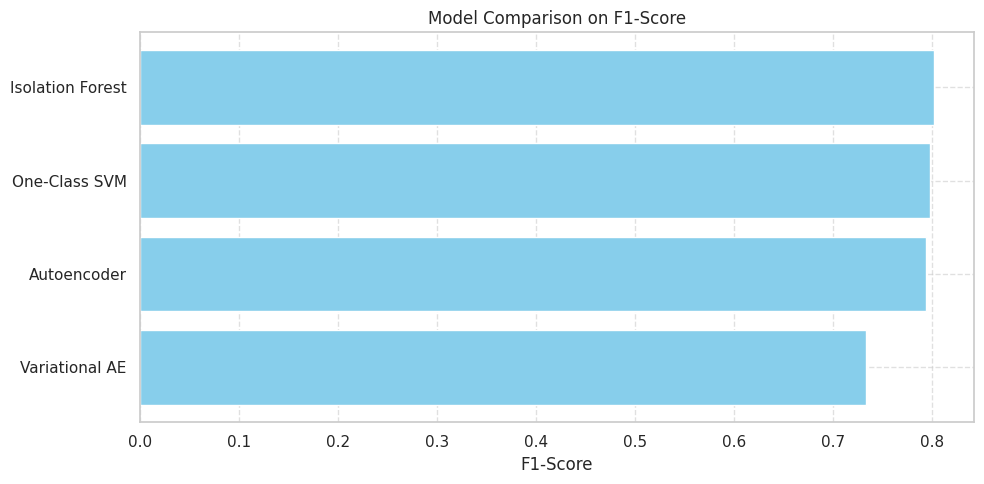

✅ 图表已保存为 model_comparison.png


In [78]:
#比较结果展示
results = []

# AE 评估
ae_y_pred, ae_scores = evaluate_reconstruction_model(
    model=best_model,
    X_train=X_train_transformed,
    X_test=X_test_transformed,
    y_test=y_test,
    model_name="Autoencoder"
)
results.append(collect_evaluation_metrics(y_test, ae_y_pred, ae_scores, model_name='Autoencoder'))

# VAE 评估
vae_y_pred, vae_scores = evaluate_reconstruction_model(
    model=best_vae,
    X_train=X_train_transformed,
    X_test=X_test_transformed,
    y_test=y_test,
    model_name="Variational Autoencoder"
)
results.append(collect_evaluation_metrics(y_test, vae_y_pred, vae_scores, model_name='Variational AE'))

# Isolation Forest（原始特征）
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train_transformed)
iso_pred = (iso_forest.predict(X_test_transformed) == -1).astype(int)
iso_scores = -iso_forest.score_samples(X_test_transformed)
results.append(collect_evaluation_metrics(y_test, iso_pred, iso_scores, model_name='Isolation Forest'))

# One-Class SVM（原始特征）
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_transformed)
svm_pred = (ocsvm.predict(X_test_transformed) == -1).astype(int)
svm_scores = -ocsvm.decision_function(X_test_transformed)
results.append(collect_evaluation_metrics(y_test, svm_pred, svm_scores, model_name='One-Class SVM'))

# 最后展示表格和图表
df_results = display_comparison_table(results)
plot_comparison_bar(df_results, metric='F1-Score')